In [135]:
#import libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from collections import Counter



from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, learning_curve, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.inspection import permutation_importance

from scipy import stats
from scipy.stats import randint
from scipy.stats import uniform

!pip install imbalanced-learn


In [2]:
# Iaps
df_ia = pd.read_csv('iaps.csv')
df_ia.head()

,user_id,ts,date,prod_name,prod_type,rev
0,7480,2019-03-04 08:15:49,2019-03-04,iap_1_gems_2,gems,760
1,7480,2019-03-04 08:24:15,2019-03-04,iap_1_passes_2,chapterPasses,760
2,7480,2019-03-04 22:49:08,2019-03-04,iap_1_gems_1,gems,410
3,2466,2019-03-06 00:16:48,2019-03-06,iap_1_gems_2,gems,760
4,22001,2019-03-06 09:13:45,2019-03-06,iap_1_gems_2,gems,760


In [3]:
# Total number of rows and columns
df_ia.shape

(6685, 6)

In [4]:
# Check the types of Data
df_ia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6685 entries, 0 to 6684
Data columns (total 6 columns):
user_id      6685 non-null int64
ts           6685 non-null object
date         6685 non-null object
prod_name    6685 non-null object
prod_type    6685 non-null object
rev          6685 non-null int64
dtypes: int64(2), object(4)
memory usage: 209.0+ KB


In [5]:
# Check for missing or NaN data - No missing value
print(df_ia.isnull().sum())

user_id      0
ts           0
date         0
prod_name    0
prod_type    0
rev          0
dtype: int64


In [6]:
# True if duplicates are present - Duplicates exist
df_ia.duplicated().any()

True

In [7]:
# Drop duplicates
df_ia_nd = df_ia.drop_duplicates()
df_ia_nd

,user_id,ts,date,prod_name,prod_type,rev
0,7480,2019-03-04 08:15:49,2019-03-04,iap_1_gems_2,gems,760
1,7480,2019-03-04 08:24:15,2019-03-04,iap_1_passes_2,chapterPasses,760
2,7480,2019-03-04 22:49:08,2019-03-04,iap_1_gems_1,gems,410
3,2466,2019-03-06 00:16:48,2019-03-06,iap_1_gems_2,gems,760
4,22001,2019-03-06 09:13:45,2019-03-06,iap_1_gems_2,gems,760
...,...,...,...,...,...,...
6680,18174,2019-04-21 18:50:42,2019-04-21,iap_1_passes_10,chapterPasses,3555
6681,18174,2019-04-21 18:51:29,2019-04-21,iap_1_passes_1,chapterPasses,410
6682,18174,2019-04-21 20:08:06,2019-04-21,iap_1_passes_10,chapterPasses,3555
6683,18174,2019-04-22 17:07:19,2019-04-22,iap_1_passes_2,chapterPasses,760


In [8]:
# Count of distinct User_id in IAPS
count_ia = df_ia_nd['user_id'].nunique()
count_ia

1526

In [9]:
# Earliest Puchase Date, Purchase Times, Total Revenue for Each User
df_purc = df_ia_nd.groupby('user_id').agg(First_purchase = ('date','min'), Purchase_times = ('date', 'count'), Product_num = ('prod_name', 'nunique'),ProductType_num = ('prod_type','nunique'), Total_revenue = ('rev','sum'))
df_purc = df_purc.reset_index()
df_purc

,user_id,First_purchase,Purchase_times,Product_num,ProductType_num,Total_revenue
0,2,2019-03-07,1,1,1,760
1,21,2019-03-09,3,2,2,2280
2,36,2019-03-02,6,3,2,4560
3,51,2019-03-02,10,4,2,6550
4,85,2019-04-17,1,1,1,760
...,...,...,...,...,...,...
1521,22528,2019-03-11,5,3,2,4850
1522,22536,2019-03-05,2,1,1,1520
1523,22544,2019-03-20,4,2,1,1990
1524,22547,2019-03-05,10,2,2,7600


In [10]:
# Session
df_se = pd.read_csv('sessions.csv')
df_se.head()

,user_id,ts,date,session_num,last_session_termination_type
0,14067,2019-03-01 00:06:50,2019-03-01,1,NaN
1,14067,2019-03-01 00:22:27,2019-03-01,2,NaN
2,16275,2019-03-01 01:23:03,2019-03-01,1,NaN
3,16275,2019-03-01 01:31:16,2019-03-01,2,NaN
4,16275,2019-03-01 01:47:22,2019-03-01,3,NaN


In [11]:
# Total number of rows and columns
df_se.shape

(722955, 5)

In [12]:
# Check the types of Data
df_se.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 722955 entries, 0 to 722954
Data columns (total 5 columns):
user_id                          722955 non-null int64
ts                               722955 non-null object
date                             722955 non-null object
session_num                      722955 non-null int64
last_session_termination_type    0 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 22.1+ MB


In [13]:
# Check for missing or NaN data - 722955 NaN value in last_session_termination_type
print(df_se.isnull().sum())

user_id                               0
ts                                    0
date                                  0
session_num                           0
last_session_termination_type    722955
dtype: int64


In [14]:
# True if duplicates are present - Duplicates exist
df_se.duplicated().any()

True

In [15]:
# Drop duplicates & missing value
df_se_nd = df_se.drop_duplicates()
df_se_ndna = df_se_nd.dropna(axis='columns')
df_se_ndna

,user_id,ts,date,session_num
0,14067,2019-03-01 00:06:50,2019-03-01,1
1,14067,2019-03-01 00:22:27,2019-03-01,2
2,16275,2019-03-01 01:23:03,2019-03-01,1
3,16275,2019-03-01 01:31:16,2019-03-01,2
4,16275,2019-03-01 01:47:22,2019-03-01,3
...,...,...,...,...
722950,6780,2019-05-02 21:56:18,2019-05-02,101
722951,6780,2019-05-02 22:17:31,2019-05-02,102
722952,6780,2019-05-02 22:42:50,2019-05-02,103
722953,905,2019-05-04 16:50:52,2019-05-04,89


In [16]:
# Earliest Session Date, Session Times
df_sess = df_se_ndna.groupby('user_id').agg(First_session = ('date','min'), Session_times = ('session_num', 'max'))
df_sess = df_sess.reset_index()
df_sess

,user_id,First_session,Session_times
0,0,2019-03-01,12
1,1,2019-03-01,33
2,2,2019-03-06,38
3,3,2019-03-03,3
4,4,2019-03-03,3
...,...,...,...
22539,22571,2019-03-01,4
22540,22572,2019-03-06,5
22541,22573,2019-03-05,16
22542,22574,2019-03-02,2


In [17]:
# Spendevents
df_sp = pd.read_csv('spendevents.csv')
df_sp.head()

,user_id,ts,date,story,chapter,spendtype,currency,amount
0,9829,2019-03-01 03:03:04,2019-03-01,story_1,0,earnGemsCounter,gems,-22
1,13757,2019-03-01 03:35:53,2019-03-01,story_1,0,earnGemsCounter,gems,-22
2,13757,2019-03-01 03:52:10,2019-03-01,story_2,0,earnGemsCounter,gems,-22
3,10009,2019-03-01 04:10:00,2019-03-01,story_1,0,earnGemsCounter,gems,-22
4,10009,2019-03-01 04:26:46,2019-03-01,story_2,0,earnGemsCounter,gems,-22


In [18]:
# Total number of rows and columns
df_sp.shape

(107764, 8)

In [19]:
# Check the types of Data
df_sp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107764 entries, 0 to 107763
Data columns (total 8 columns):
user_id      107764 non-null int64
ts           107764 non-null object
date         107764 non-null object
story        107764 non-null object
chapter      107764 non-null int64
spendtype    106420 non-null object
currency     107764 non-null object
amount       107764 non-null int64
dtypes: int64(3), object(5)
memory usage: 4.5+ MB


In [20]:
# Check for missing or NaN data - 1344 missing value in spendtype
print(df_sp.isnull().sum())

user_id         0
ts              0
date            0
story           0
chapter         0
spendtype    1344
currency        0
amount          0
dtype: int64


In [21]:
# True if duplicates are present - Duplicates exist
df_sp.duplicated().any()

True

In [22]:
# Drop duplicates & missing value
df_sp_nd = df_sp.drop_duplicates()
df_sp_nd


,user_id,ts,date,story,chapter,spendtype,currency,amount
0,9829,2019-03-01 03:03:04,2019-03-01,story_1,0,earnGemsCounter,gems,-22
1,13757,2019-03-01 03:35:53,2019-03-01,story_1,0,earnGemsCounter,gems,-22
2,13757,2019-03-01 03:52:10,2019-03-01,story_2,0,earnGemsCounter,gems,-22
3,10009,2019-03-01 04:10:00,2019-03-01,story_1,0,earnGemsCounter,gems,-22
4,10009,2019-03-01 04:26:46,2019-03-01,story_2,0,earnGemsCounter,gems,-22
...,...,...,...,...,...,...,...,...
107759,15156,2019-04-23 02:31:46,2019-04-23,story_3,0,earnGemsCounter,gems,0
107760,15156,2019-04-23 02:31:59,2019-04-23,story_3,0,earnGemsCounter,gems,0
107761,15156,2019-04-23 02:32:04,2019-04-23,story_3,0,earnGemsCounter,gems,0
107762,15156,2019-04-23 02:32:11,2019-04-23,story_3,0,earnGemsCounter,gems,0


In [23]:
# Earliest Spend Date, Spend Times, Number of Spend Types, Total Spend Amount for Each User
df_spen = df_sp_nd.groupby('user_id').agg(First_spend = ('date','min'), Spend_times = ('date', 'count'), Spend_types = ('spendtype','nunique'), Story_num = ('story', 'nunique'), Chapter_num = ('chapter', 'nunique'), Total_spend = ('amount','sum'))
df_spen = df_spen.reset_index()
df_spen

,user_id,First_spend,Spend_times,Spend_types,Story_num,Chapter_num,Total_spend
0,0,2019-03-01,1,1,1,1,-22
1,1,2019-03-02,2,1,2,1,-44
2,2,2019-03-06,7,3,3,3,-43
3,3,2019-03-03,1,1,1,1,-22
4,4,2019-03-03,1,1,1,1,-22
...,...,...,...,...,...,...,...
18012,22570,2019-03-05,17,2,4,5,-35
18013,22571,2019-03-11,1,1,1,1,-22
18014,22572,2019-03-06,1,1,1,1,-22
18015,22573,2019-03-05,2,1,2,1,-44


In [24]:
# Users
df_us = pd.read_csv('users.csv')
df_us.head()

,user_id,install_date,lang,country,hw_ver,os_ver
0,0,2019-03-01,en,US,"iPhone4,1",9.1
1,1,2019-03-01,en,IN,"iPod5,1",8.1.2
2,2,2019-03-06,en,US,"iPod7,1",8.4.1
3,3,2019-03-03,nb,NO,"iPhone8,1",9.2.1
4,4,2019-03-03,en,GB,"iPhone5,4",9.2.1


In [25]:
# Total number of rows and columns
df_us.shape

(22576, 6)

In [26]:
# Check the types of Data
df_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22576 entries, 0 to 22575
Data columns (total 6 columns):
user_id         22576 non-null int64
install_date    22576 non-null object
lang            22576 non-null object
country         22564 non-null object
hw_ver          22576 non-null object
os_ver          22576 non-null object
dtypes: int64(1), object(5)
memory usage: 617.4+ KB


In [27]:
# Check for missing or NaN data - 12 missing value in country
print(df_us.isnull().sum())

user_id          0
install_date     0
lang             0
country         12
hw_ver           0
os_ver           0
dtype: int64


In [28]:
# True if duplicates are present - No duplicates
df_us.duplicated().any()

False

In [29]:
# Drop missing Value
df_us.dropna()

,user_id,install_date,lang,country,hw_ver,os_ver
0,0,2019-03-01,en,US,"iPhone4,1",9.1
1,1,2019-03-01,en,IN,"iPod5,1",8.1.2
2,2,2019-03-06,en,US,"iPod7,1",8.4.1
3,3,2019-03-03,nb,NO,"iPhone8,1",9.2.1
4,4,2019-03-03,en,GB,"iPhone5,4",9.2.1
...,...,...,...,...,...,...
22571,22571,2019-03-01,en,US,"iPhone4,1",8.3
22572,22572,2019-03-06,fr,FR,"iPhone6,2",9.2.1
22573,22573,2019-03-05,en,GB,"iPad2,5",8.3
22574,22574,2019-03-02,en,US,"iPhone8,1",9.1


In [179]:
# Install + Session + Spend + Purchase
df_is = pd.merge(df_us, df_sess, how = 'outer')
df_iss = pd.merge(df_is, df_spen, how = 'outer')
df_issp = pd.merge(df_iss, df_purc, how = 'outer')
df_issp['Purchase_times'] = df_issp['Purchase_times'].fillna(0).astype(int)
df_issp['Spend_types'] = df_issp['Spend_types'].fillna(0).astype(int)
df_issp['Story_num'] = df_issp['Story_num'].fillna(0).astype(int)
df_issp['Chapter_num'] = df_issp['Chapter_num'].fillna(0).astype(int)
df_issp['Product_num'] = df_issp['Product_num'].fillna(0).astype(int)
df_issp['ProductType_num'] = df_issp['ProductType_num'].fillna(0).astype(int)
df_issp['Session_times'] = df_issp['Session_times'].fillna(0).astype(int)
df_issp['Spend_times'] = df_issp['Spend_times'].fillna(0).astype(int)
df_issp['Total_spend'] = df_issp['Total_spend'].fillna(0).astype(int)
df_issp['Total_revenue'] = df_issp['Total_revenue'].fillna(0).astype(int)
df_issp

,user_id,install_date,lang,country,hw_ver,os_ver,First_session,Session_times,First_spend,Spend_times,Spend_types,Story_num,Chapter_num,Total_spend,First_purchase,Purchase_times,Product_num,ProductType_num,Total_revenue
0,0,2019-03-01,en,US,"iPhone4,1",9.1,2019-03-01,12,2019-03-01,1,1,1,1,-22,NaN,0,0,0,0
1,1,2019-03-01,en,IN,"iPod5,1",8.1.2,2019-03-01,33,2019-03-02,2,1,2,1,-44,NaN,0,0,0,0
2,2,2019-03-06,en,US,"iPod7,1",8.4.1,2019-03-06,38,2019-03-06,7,3,3,3,-43,2019-03-07,1,1,1,760
3,3,2019-03-03,nb,NO,"iPhone8,1",9.2.1,2019-03-03,3,2019-03-03,1,1,1,1,-22,NaN,0,0,0,0
4,4,2019-03-03,en,GB,"iPhone5,4",9.2.1,2019-03-03,3,2019-03-03,1,1,1,1,-22,NaN,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22571,22571,2019-03-01,en,US,"iPhone4,1",8.3,2019-03-01,4,2019-03-11,1,1,1,1,-22,NaN,0,0,0,0
22572,22572,2019-03-06,fr,FR,"iPhone6,2",9.2.1,2019-03-06,5,2019-03-06,1,1,1,1,-22,NaN,0,0,0,0
22573,22573,2019-03-05,en,GB,"iPad2,5",8.3,2019-03-05,16,2019-03-05,2,1,2,1,-44,NaN,0,0,0,0
22574,22574,2019-03-02,en,US,"iPhone8,1",9.1,2019-03-02,2,NaN,0,0,0,0,0,NaN,0,0,0,0


In [180]:
df_issp_1 = df_issp.drop(columns = ['user_id'])
df_issp_1.loc[df_issp['Total_revenue'] == 0,'Conversion_Flag'] = '0'
df_issp_1['Conversion_Flag'].fillna('1', inplace=True)
df_issp_1

,install_date,lang,country,hw_ver,os_ver,First_session,Session_times,First_spend,Spend_times,Spend_types,Story_num,Chapter_num,Total_spend,First_purchase,Purchase_times,Product_num,ProductType_num,Total_revenue,Conversion_Flag
0,2019-03-01,en,US,"iPhone4,1",9.1,2019-03-01,12,2019-03-01,1,1,1,1,-22,NaN,0,0,0,0,0
1,2019-03-01,en,IN,"iPod5,1",8.1.2,2019-03-01,33,2019-03-02,2,1,2,1,-44,NaN,0,0,0,0,0
2,2019-03-06,en,US,"iPod7,1",8.4.1,2019-03-06,38,2019-03-06,7,3,3,3,-43,2019-03-07,1,1,1,760,1
3,2019-03-03,nb,NO,"iPhone8,1",9.2.1,2019-03-03,3,2019-03-03,1,1,1,1,-22,NaN,0,0,0,0,0
4,2019-03-03,en,GB,"iPhone5,4",9.2.1,2019-03-03,3,2019-03-03,1,1,1,1,-22,NaN,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22571,2019-03-01,en,US,"iPhone4,1",8.3,2019-03-01,4,2019-03-11,1,1,1,1,-22,NaN,0,0,0,0,0
22572,2019-03-06,fr,FR,"iPhone6,2",9.2.1,2019-03-06,5,2019-03-06,1,1,1,1,-22,NaN,0,0,0,0,0
22573,2019-03-05,en,GB,"iPad2,5",8.3,2019-03-05,16,2019-03-05,2,1,2,1,-44,NaN,0,0,0,0,0
22574,2019-03-02,en,US,"iPhone8,1",9.1,2019-03-02,2,NaN,0,0,0,0,0,NaN,0,0,0,0,0


In [184]:
# Visulaization
payer = df_issp_1[df_issp_1['Conversion_Flag'] == "Payers"]
nonpayer = df_issp_1[df_issp_1['Conversion_Flag'] == "NonPayers"]

def plot_compare(column, category_name):
    N_payer = len(payer[column].unique())
    N_Nonpayer = len(nonpayer[column].unique())
    
    PayerCounts = payer[column].value_counts().sort_index()
    NonpayerCounts = nonpayer[column].value_counts().sort_index()
    
    indpayer = np.arange(N_payer)    
    indnonpayer = np.arange(N_Nonpayer)    
    width = 1       
    
    figs, axs = plt.subplots(1,2, figsize=(12,5))
    
    axs[1].bar(indpayer, PayerCounts, width, color ='#EDA577' )
    axs[1].set_title('payer ' + category_name, fontsize=18)
    axs[1].set_xticks(indpayer)
    axs[1].set_xticklabels(PayerCounts.index.tolist(), rotation=45)
    
    axs[0].bar(indnonpayer, NonpayerCounts, width, color ='#6182B2')
    axs[0].set_title('Nonpayer ' + category_name, fontsize=18)
    axs[0].set_ylabel('Number of Users')
    axs[0].set_xticks(indnonpayer)
    axs[0].set_xticklabels(NonpayerCounts.index.tolist(), rotation=45)
    
    plt.show()


def plot_pie(column):
    target = df_issp_1[column].value_counts()    
    fig1, ax1 = plt.subplots()    
    ax1.pie(target, labels=target.index, autopct='%1.1f%%', shadow=None)
    ax1.axis('equal')
    plt.title(column, fontsize=14)
    plt.show()

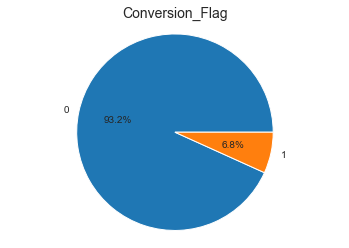

In [187]:
#Percentage of Payer(1) and Nonpayers(0)--Imbalanced, need upsampling
plot_pie('Conversion_Flag')

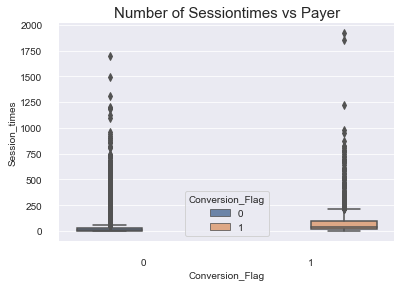

In [188]:
#Number of Sessiontime distribution vs Payer
sns.boxplot(x="Conversion_Flag", y="Session_times",
            hue="Conversion_Flag", palette=["#6182B2", "#EDA577"],
            data=df_issp_1).set_title("Number of Sessiontimes vs Payer", fontsize=15)
sns.despine(offset=10, trim=True)

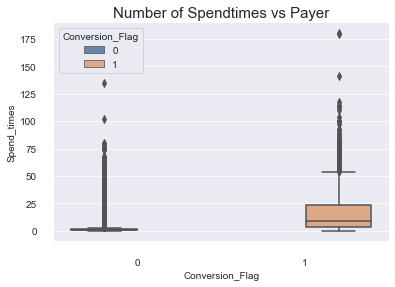

In [189]:
#Number of Spendtime distribution vs Payer
sns.boxplot(x="Conversion_Flag", y="Spend_times",
            hue="Conversion_Flag", palette=["#6182B2", "#EDA577"],
            data=df_issp_1).set_title("Number of Spendtimes vs Payer", fontsize=15)
sns.despine(offset=10, trim=True)

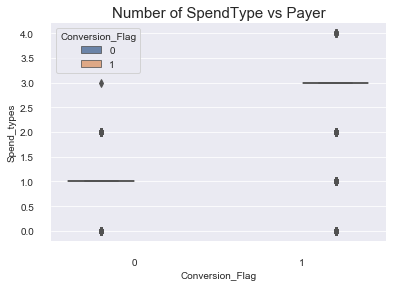

In [190]:
#Number od Spendtype distribution vs Payer
sns.boxplot(x="Conversion_Flag", y="Spend_types",
            hue="Conversion_Flag", palette=["#6182B2", "#EDA577"],
            data=df_issp_1).set_title("Number of SpendType vs Payer", fontsize=15)
sns.despine(offset=10, trim=True)


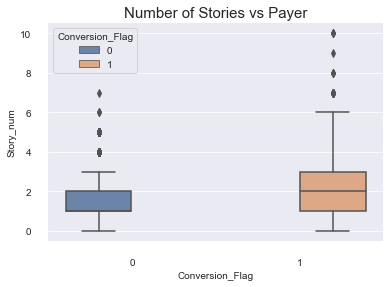

In [191]:
#Number od Stories distribution vs Payer
sns.boxplot(x="Conversion_Flag", y="Story_num",
            hue="Conversion_Flag", palette=["#6182B2", "#EDA577"],
            data=df_issp_1).set_title("Number of Stories vs Payer", fontsize=15)
sns.despine(offset=10, trim=True)


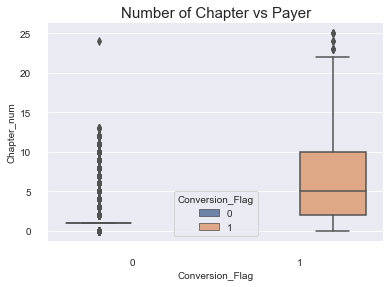

In [192]:
#Number od Chapters distribution vs Payer
sns.boxplot(x="Conversion_Flag", y="Chapter_num",
            hue="Conversion_Flag", palette=["#6182B2", "#EDA577"],
            data=df_issp_1).set_title("Number of Chapter vs Payer", fontsize=15)
sns.despine(offset=10, trim=True)


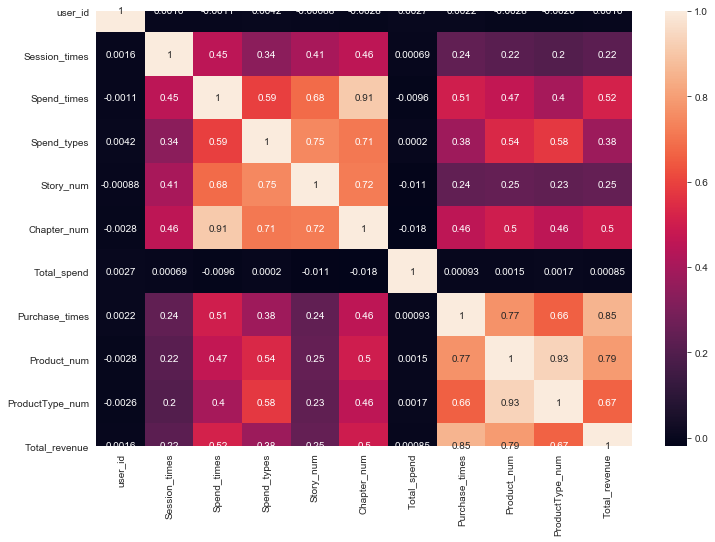

In [193]:
# Correlations: to Revenue  -- Spend_times, Chapter_num
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df_issp.corr(),  annot=True)
plt.show()

In [34]:
from sklearn import metrics 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [35]:
#drop highly correlated and no correlated columns
df_issp_2 = df_issp.drop(columns = ['install_date','lang','country','os_ver','hw_ver','First_session','First_spend','First_purchase', 'Purchase_times', 'Product_num', 'ProductType_num', 'Total_revenue'])
df_issp_2

,user_id,Session_times,Spend_times,Spend_types,Story_num,Chapter_num,Total_spend,Conversion_Flag
0,0,12,1,1,1,1,-22,0.0
1,1,33,2,1,2,1,-44,0.0
2,2,38,7,3,3,3,-43,1.0
3,3,3,1,1,1,1,-22,0.0
4,4,3,1,1,1,1,-22,0.0
...,...,...,...,...,...,...,...,...
22571,22571,4,1,1,1,1,-22,0.0
22572,22572,5,1,1,1,1,-22,0.0
22573,22573,16,2,1,2,1,-44,0.0
22574,22574,2,0,0,0,0,0,0.0


In [36]:
train, test = train_test_split(df_issp_2, test_size=0.2, random_state=25)

print(f"No. of training examples: {train.shape[0]}")
print(f"No. of testing examples: {test.shape[0]}")


No. of training examples: 18060
No. of testing examples: 4516


In [37]:
train.isnull().sum()

user_id            0
Session_times      0
Spend_times        0
Spend_types        0
Story_num          0
Chapter_num        0
Total_spend        0
Conversion_Flag    0
dtype: int64

In [38]:
train['Conversion_Flag'] = train.Conversion_Flag.astype(int)
train.dtypes

C:\Users\Kangaroo Sissi\Documents\BAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


user_id            int64
Session_times      int32
Spend_times        int32
Spend_types        int32
Story_num          int32
Chapter_num        int32
Total_spend        int32
Conversion_Flag    int32
dtype: object

In [39]:
test.isnull().sum()

user_id            0
Session_times      0
Spend_times        0
Spend_types        0
Story_num          0
Chapter_num        0
Total_spend        0
Conversion_Flag    0
dtype: int64

In [40]:
test['Conversion_Flag'] = test.Conversion_Flag.astype(int)
test.dtypes

C:\Users\Kangaroo Sissi\Documents\BAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


user_id            int64
Session_times      int32
Spend_times        int32
Spend_types        int32
Story_num          int32
Chapter_num        int32
Total_spend        int32
Conversion_Flag    int32
dtype: object

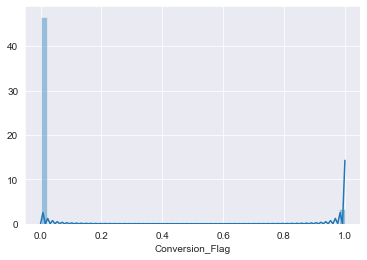

In [41]:
sns.distplot(train['Conversion_Flag'])

In [42]:
import collections
from collections import Counter
counter = Counter(train.Conversion_Flag)
for k,v in counter.items():
    per = v / len(train.Conversion_Flag) * 100
    print('Class=%s, Count=%d, Percentage=%.3f%%' % (k,v,per))

Class=0, Count=16840, Percentage=93.245%
Class=1, Count=1220, Percentage=6.755%


In [43]:
# Convert objects to integers
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

train.Conversion_Flag = le.fit_transform(train.Conversion_Flag)



C:\Users\Kangaroo Sissi\Documents\BAN\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [44]:
# Define x,y,and x_test

y = train.Conversion_Flag
x = train.drop(['Conversion_Flag','user_id'], axis = 1)
x_test = test.drop(['user_id', 'Conversion_Flag'], axis = 1)
x.shape, y.shape, x_test.shape

((18060, 6), (18060,), (4516, 6))

In [45]:
# Split into validation and training data
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, random_state = 1, test_size = 0.10, stratify = y)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((16254, 6), (1806, 6), (16254,), (1806,))

In [166]:
#use SMOTE to oversample
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
x_train_upsampled, y_train_upsampled = oversample.fit_resample(x_train,y_train)

In [167]:
# Class Weights
from sklearn.utils import class_weight

class_weights = dict(zip(np.unique(y_train_upsampled), class_weight.compute_class_weight('balanced', np.unique(y_train_upsampled), y_train_upsampled)))


C:\Users\Kangaroo Sissi\Documents\BAN\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[0 1], y=0        0
1        0
2        0
3        0
4        1
        ..
30307    1
30308    1
30309    1
30310    1
30311    1
Name: Conversion_Flag, Length: 30312, dtype: int32 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [168]:
# Define model
## XGB Classifer
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score



In [169]:
# XGB: 0.983450 (0.002324)
model = XGBClassifier()
name = 'XGB'

kfold = StratifiedKFold(n_splits = 10, random_state = 1, shuffle = True)
cv_results = cross_val_score(model, x_train, y_train, cv = kfold, scoring = 'accuracy')
print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

C:\Users\Kangaroo Sissi\Documents\BAN\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:11:50] WARNING: D:\Build\xgboost\xgboost-1.4.2.git\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Kangaroo Sissi\Documents\BAN\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:11:51] WARNING: D:\Build\xgboost\xgboost-1.4.2.git\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Kangaroo Sissi\Documents\BAN\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:11:51] WARNING: D:\Build\xgboost\xgboost-1.4.2.git\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Kangaroo Sissi\Documents\BAN\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:11:52] WARNING: D:\Build\xgboost\xgboost-1.4.2.git\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Kangaroo Sissi\Documents\BAN\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:11:53] WARNING: D:\Build\xgboost\xgboost-1.4.2.git\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Kangaroo Sissi\Documents\BAN\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:11:53] WARNING: D:\Build\xgboost\xgboost-1.4.2.git\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Kangaroo Sissi\Documents\BAN\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:11:54] WARNING: D:\Build\xgboost\xgboost-1.4.2.git\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Kangaroo Sissi\Documents\BAN\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:11:54] WARNING: D:\Build\xgboost\xgboost-1.4.2.git\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Kangaroo Sissi\Documents\BAN\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:11:55] WARNING: D:\Build\xgboost\xgboost-1.4.2.git\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Kangaroo Sissi\Documents\BAN\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:11:56] WARNING: D:\Build\xgboost\xgboost-1.4.2.git\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB: 0.983450 (0.002324)


In [170]:
# Make predictions on validation dataset
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

model = XGBClassifier(learning_rate = 1, n_estimators = 2000, max_depth = 40, min_child_weight = 40,
                     gamma = 0.4, nthread = 10, subsample = 0.8, colsample_bytree =.8,
                     objective = 'binary:logistic', scale_pos_weight = 10, seed = 29, class_weight = class_weights)
model.fit(x_train_upsampled, y_train_upsampled)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_upsampled, model.predict(x_train_upsampled))
print(auc(false_positive_rate, true_positive_rate)) # 0.8764845605700712

C:\Users\Kangaroo Sissi\Documents\BAN\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:12:26] WARNING: D:\Build\xgboost\xgboost-1.4.2.git\src\learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:12:26] WARNING: D:\Build\xgboost\xgboost-1.4.2.git\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8764845605700712


In [219]:
#XGB Evaluation :The accurarcy is 75%, the recall is 86.88%.
# Predicting result for training set and validation set
XGBPrediction = model.predict(x_val)

# Model Performance
print("Accuracy : ", accuracy_score(y_val, XGBPrediction) *  100)
print("Recall : ", recall_score(y_val, XGBPrediction) *  100)
print("Precision : ", precision_score(y_val, XGBPrediction) *  100)
print("Overall f1-score:", f1_score(y_val, XGBPrediction))
print(confusion_matrix(y_val, XGBPrediction))
print(classification_report(y_val, XGBPrediction))

Accuracy :  75.47065337763013
Recall :  86.88524590163934
Precision :  19.887429643527206
Overall f1-score: 0.3236641221374046
[[1257  427]
 [  16  106]]
              precision    recall  f1-score   support

           0       0.99      0.75      0.85      1684
           1       0.20      0.87      0.32       122

    accuracy                           0.75      1806
   macro avg       0.59      0.81      0.59      1806
weighted avg       0.93      0.75      0.81      1806



In [220]:
# XGB Hyperparameter Tuning

params = {
    "colsample_bytree": uniform(0.3, 0.7),
    "min_child_weight": [1,2,3,4],
    "learning_rate": uniform(0.1, 0.5), # default 0.1 
    "max_depth": randint(6, 9), # default 3
    "n_estimators": randint(100, 300), # default 100
    "subsample": uniform(0.6, 0.4)
}

xgbnew = XGBClassifier()

search = RandomizedSearchCV(xgbnew, param_distributions=params, random_state=123, n_iter=100, cv=3, verbose=2, n_jobs=-1)

search.fit(x_train_upsampled, y_train_upsampled)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\Kangaroo Sissi\Documents\BAN\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:56:41] WARNING: D:\Build\xgboost\xgboost-1.4.2.git\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x16D90D70>,
                                        'max_depth': <sc

In [221]:
search.best_params_

{'colsample_bytree': 0.9111833141203842,
 'learning_rate': 0.1839442223336494,
 'max_depth': 7,
 'min_child_weight': 4,
 'n_estimators': 285,
 'subsample': 0.9934086436814222}

In [223]:
myxgb = search.best_estimator_
y_pred = myxgb.predict(x_val.values)

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1684
           1       0.58      0.79      0.67       122

    accuracy                           0.95      1806
   macro avg       0.78      0.87      0.82      1806
weighted avg       0.96      0.95      0.95      1806



In [224]:
print("Accuracy : ", accuracy_score(y_val, y_pred) *  100)
print("Recall : ", recall_score(y_val, y_pred) *  100)
print("Precision : ", precision_score(y_val, y_pred) *  100)
print("Overall f1-score:", f1_score(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))
auc = roc_auc_score(y_val,y_pred)
print("AUC:", auc)
plt.show()

Accuracy :  94.73975636766335
Recall :  78.68852459016394
Precision :  58.18181818181818
Overall f1-score: 0.6689895470383275
[[1615   69]
 [  26   96]]
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1684
           1       0.58      0.79      0.67       122

    accuracy                           0.95      1806
   macro avg       0.78      0.87      0.82      1806
weighted avg       0.96      0.95      0.95      1806

AUC: 0.8729556870838363


In [225]:
df = pd.DataFrame({'Actual': y_val, 'Predicted': y_pred})
df

,Actual,Predicted
3407,0,0
3624,0,0
3665,0,0
21909,0,0
3823,0,0
...,...,...
7475,0,1
11394,0,0
3284,0,1
7384,0,0


In [226]:
Probability = model.predict_proba(x_test)[:,1]
Probability

array([8.7662596e-01, 3.3166859e-04, 6.0762954e-01, ..., 9.4414368e-02,
       7.0410269e-06, 1.6559972e-01], dtype=float32)

In [227]:
result = pd.DataFrame({'user_id': test.user_id, 'Conversion': Probability})
final_result = result.reset_index(drop = True)
final_result

,user_id,Conversion
0,16443,0.876626
1,6535,0.000332
2,10825,0.607630
3,9778,0.000107
4,1585,0.607630
...,...,...
4511,19937,0.213696
4512,15062,0.607630
4513,18687,0.094414
4514,18774,0.000007


In [228]:
final_profile = pd.merge(final_result, df_issp, how = 'inner')
final_profile

,user_id,Conversion,install_date,lang,country,hw_ver,os_ver,First_session,Session_times,First_spend,Spend_times,Spend_types,Story_num,Chapter_num,Total_spend,First_purchase,Purchase_times,Product_num,ProductType_num,Total_revenue
0,16443,0.876626,2019-03-01,sv,SE,"iPhone8,1",9.1,2019-03-01,20,2019-03-01,1,1,1,1,-22,NaN,0,0,0,0
1,6535,0.000332,2019-03-03,en,US,"iPhone7,1",9.1,2019-03-03,19,2019-03-03,2,1,2,1,-44,NaN,0,0,0,0
2,10825,0.607630,2019-03-01,en,US,"iPhone6,1",9.2.1,2019-03-01,7,2019-03-07,1,1,1,1,-22,NaN,0,0,0,0
3,9778,0.000107,2019-03-04,en,US,"iPhone8,1",9.2.1,2019-03-04,1,2019-03-04,1,1,1,1,-22,NaN,0,0,0,0
4,1585,0.607630,2019-03-05,en,US,"iPhone5,3",9.2.1,2019-03-05,7,2019-03-05,1,1,1,1,-22,NaN,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4511,19937,0.213696,2019-03-04,en,US,"iPod7,1",9.2.1,2019-03-04,1,NaN,0,0,0,0,0,NaN,0,0,0,0
4512,15062,0.607630,2019-03-01,en,CA,"iPhone6,1",9.2,2019-03-01,7,2019-03-01,1,1,1,1,-22,NaN,0,0,0,0
4513,18687,0.094414,2019-03-07,en,US,"iPad4,1",9.0.2,2019-03-07,4,2019-03-07,1,1,1,1,-22,NaN,0,0,0,0
4514,18774,0.000007,2019-03-01,es,MX,"iPad2,5",8.4,2019-03-01,4,2019-03-01,2,1,2,1,-44,NaN,0,0,0,0


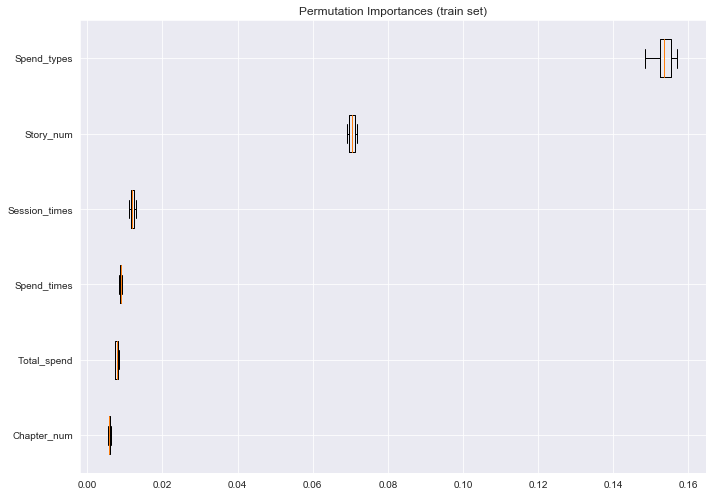

In [229]:
model = ExtraTreesClassifier()
model.fit(x_train,y_train)
resultmymodel = permutation_importance(model, x_train, y_train, n_repeats=10,random_state=123, n_jobs=2)
sorted_idx = resultmymodel.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(10,7))
ax.boxplot(resultmymodel.importances[sorted_idx].T,vert=False, labels=x_train.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

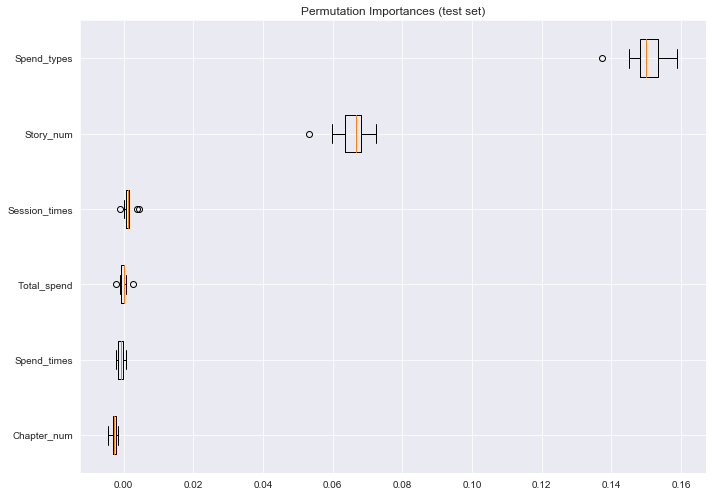

In [230]:
resultmymodel = permutation_importance(model, x_val, y_val, n_repeats=10,random_state=123, n_jobs=2)
sorted_idx = resultmymodel.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(10,7))
ax.boxplot(resultmymodel.importances[sorted_idx].T,vert=False, labels=x_val.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

In [233]:
# Mean--Target
final_profile['Conversion'].mean()

0.31857967376708984

In [234]:
target = final_profile.loc[final_profile['Conversion'] > 0.32]
target

,user_id,Conversion,install_date,lang,country,hw_ver,os_ver,First_session,Session_times,First_spend,Spend_times,Spend_types,Story_num,Chapter_num,Total_spend,First_purchase,Purchase_times,Product_num,ProductType_num,Total_revenue
0,16443,0.876626,2019-03-01,sv,SE,"iPhone8,1",9.1,2019-03-01,20,2019-03-01,1,1,1,1,-22,NaN,0,0,0,0
2,10825,0.607630,2019-03-01,en,US,"iPhone6,1",9.2.1,2019-03-01,7,2019-03-07,1,1,1,1,-22,NaN,0,0,0,0
4,1585,0.607630,2019-03-05,en,US,"iPhone5,3",9.2.1,2019-03-05,7,2019-03-05,1,1,1,1,-22,NaN,0,0,0,0
6,3817,0.562448,2019-03-01,en,US,"iPhone6,1",9.1,2019-03-01,13,2019-03-01,1,1,1,1,-22,NaN,0,0,0,0
9,9493,0.553935,2019-03-05,en,US,"iPhone8,1",9.2.1,2019-03-05,5,NaN,0,0,0,0,0,NaN,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4506,3497,0.607630,2019-03-06,en,US,"iPhone7,2",9.2.1,2019-03-06,7,2019-03-06,1,1,1,1,-22,NaN,0,0,0,0
4507,2012,0.697050,2019-03-01,en,JP,"iPhone8,2",9.2.1,2019-03-01,15,NaN,0,0,0,0,0,NaN,0,0,0,0
4508,22465,0.930115,2019-03-02,ar,SA,"iPhone8,1",9.2.1,2019-03-02,13,NaN,0,0,0,0,0,NaN,0,0,0,0
4509,2549,0.427977,2019-03-06,en,US,"iPhone5,2",9.2,2019-03-06,4,NaN,0,0,0,0,0,NaN,0,0,0,0


In [235]:
# High correlated features: Spend_times, Chapter_num
Avg_Spendtimes = target['Spend_times'].mean()
Avg_Chapternum = target['Chapter_num'].mean()
print('Average of Spendtimes:', round(Avg_Spendtimes))
print('Average number of Chapters:', round(Avg_Chapternum))

Average of Spendtimes: 5
Average number of Chapters: 2


In [236]:
# Most important features: Spend_types, Story_num
Avg_Spendtypes = target['Spend_types'].mean()
Avg_Storynum = target['Story_num'].mean()
print('Average of Spendtypes:', round(Avg_Spendtypes))
print('Average number of Stories:', round(Avg_Storynum))

Average of Spendtypes: 1
Average number of Stories: 1


In [237]:
with pd.ExcelWriter('Final Result.xlsx') as writer:  
    final_profile.to_excel(writer, sheet_name='Final Profile')
    target.to_excel(writer, sheet_name='Target Group')